<a href="https://colab.research.google.com/github/windopper/NLPDeepLearningPractice/blob/main/ConvolutionNerualNetwork/movie_review_classify_using_multi_kernel_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 11.9 MB/s 
     |████████████████████████████████| 448 kB 40.6 MB/s 


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f0e67aee9d0>)

In [8]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [10]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [11]:
len(train_data)

150000

In [12]:
len(test_data)


50000

In [13]:
train_data.document.nunique(), train_data.document.nunique()

(146182, 146182)

In [14]:
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

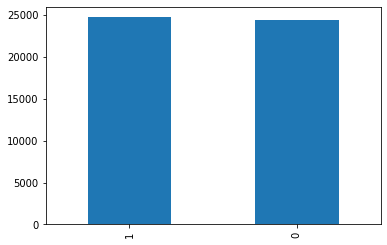

In [16]:
test_data['label'].value_counts().plot(kind='bar')

In [17]:
print(train_data.isnull().values.any())

True


In [18]:
train_data = train_data.dropna(how='any')

In [19]:
print(train_data.isnull().values.any())

False


In [21]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [22]:
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [23]:
train_data['document'].isnull().values.any()

False

In [24]:
train_data['document'] = train_data['document'].str.replace("^ +", "")
train_data['document'].replace("", np.nan, inplace=True)
print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


id            0
document    789
label         0
dtype: int64


In [25]:
train_data = train_data.dropna(how='any')
print(len(train_data))

145393


In [26]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


전처리 후 테스트용 샘플의 개수 : 48852


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [28]:
okt = Okt()

x_train = []
for sentence in tqdm(train_data['document']):
  tokenized_sentence = okt.morphs(sentence)
  stopwords_removed_sentence = [word for word in tokenized_sentence if word not in stopwords]
  x_train.append(stopwords)

100%|██████████| 145393/145393 [10:29<00:00, 230.92it/s]


In [29]:
x_test = []
for sentence in tqdm(test_data['document']):
  tokenized_sentence = okt.morphs(sentence)
  stopwords_removed_sentence = [word for word in tokenized_sentence if word not in stopwords]
  x_test.append(stopwords_removed_sentence)


100%|██████████| 48852/48852 [03:21<00:00, 243.04it/s]


In [30]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(x_train)

In [31]:
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_index.items():
  total_freq = total_freq + value

  if value < threshold:
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

In [32]:
vocab_size = total_cnt + 1

In [33]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [34]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [36]:
drop_table = [index for index, sentence in enumerate(x_train) if len(sentence) < 1]

In [41]:
x_train = np.delete(x_train, drop_table, axis=0)
y_train = np.delete(y_train, drop_table, axis=0)

In [42]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [43]:
max_len = 30
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 100.0


In [40]:
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

Multi-Kernel 1D CNN 모델 설계

In [53]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
dropout_ratio = (0.5, 0.8)
num_filters = 128
hidden_units = 128

model_input = Input(shape=(max_len,))

In [54]:
z = Embedding(vocab_size, embedding_dim, input_length=max_len, name='Embedding')(model_input)
z = Dropout(dropout_ratio[0])(z)

In [55]:
conv_blocks = []

for sz in [3, 4, 5]:
  conv = Conv1D(
      filters=num_filters,
      kernel_size=sz,
      padding='valid',
      activation='relu',
      strides=1
  )(z)
  conv = GlobalMaxPooling1D()(conv)
  conv_blocks.append(conv)

In [56]:
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_ratio[1])(z)
z = Dense(hidden_units, activation='relu')(z)
model_output = Dense(1, activation='sigmoid')(z)

model = Model(model_input, model_output)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=2, callbacks=[es, mc])

Epoch 1/10

Epoch 00001: val_acc improved from -inf to 0.49555, saving model to CNN_model.h5
1818/1818 - 40s - loss: 0.6946 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.4955 - 40s/epoch - 22ms/step
Epoch 2/10

Epoch 00002: val_acc improved from 0.49555 to 0.50445, saving model to CNN_model.h5
1818/1818 - 28s - loss: 0.6934 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5045 - 28s/epoch - 15ms/step
Epoch 3/10

Epoch 00003: val_acc did not improve from 0.50445
1818/1818 - 28s - loss: 0.6934 - acc: 0.4991 - val_loss: 0.6932 - val_acc: 0.4955 - 28s/epoch - 15ms/step
Epoch 4/10

Epoch 00004: val_acc did not improve from 0.50445
1818/1818 - 28s - loss: 0.6933 - acc: 0.5008 - val_loss: 0.6931 - val_acc: 0.5045 - 28s/epoch - 15ms/step
Epoch 5/10

Epoch 00005: val_acc did not improve from 0.50445
1818/1818 - 28s - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6931 - val_acc: 0.5045 - 28s/epoch - 15ms/step
Epoch 6/10

Epoch 00006: val_acc did not improve from 0.50445
1818/1818 - 29s - loss: 0.6933 - 

In [58]:
loaded_model = load_model('CNN_model.h5')
print('\n테스트 정확도 : ', loaded_model.evaluate(x_test, y_test)[1])

1527/1527 [==============================] - 7s 4ms/step - loss: 0.6932 - acc: 0.4981

테스트 정확도 :  0.49807581305503845


In [65]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen=max_len)
  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print('{:.2f}% 확률로 부정 리뷰입니다.\n'.format((1-score) * 100))

In [68]:
sentiment_predict('완전 재밌다')

50.14% 확률로 부정 리뷰입니다.

